In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
path = "/home/juanbetancur/analisis_datos_universidad/evento_evaluativo_4/ejercicio_3/amazon_review_lemmatized.parquet"
df = pd.read_parquet(path, engine="pyarrow")
df.head()

,rating,clean_title,clean_review,clean_review_stemming,clean_review_lemmatization
0,3,more like funchuck,gave this to my dad for a gag gift after direc...,gave dad gag gift direct nunsens got reall kick,give dad gag gift direct nunsense get reall kick
1,5,inspiring,i hope a lot of people hear this cd we need mo...,hope lot peopl hear cd need strong posit vibe ...,hope lot people hear cd need strong positive v...
2,5,the best soundtrack ever to anything,im reading a lot of reviews saying that this i...,im read lot review say best game soundtrack fi...,read lot review say good game soundtrack figur...
3,4,chrono cross ost,the music of yasunori misuda is without questi...,music yasunori misuda without question close s...,music yasunori misuda without question close s...
4,5,too good to be true,probably the greatest soundtrack in history us...,probabl greatest soundtrack histori usual bett...,probably great soundtrack history usually well...


In [4]:
print("="*60)
print("PREPARACIÓN DE DATOS")
print("="*60)

# Tamaño original
print(f"Dataset original: {len(df):,} reviews")
print(f"Distribución original:")
print(df['rating'].value_counts().sort_index())


PREPARACIÓN DE DATOS
Dataset original: 3,629,444 reviews
Distribución original:
rating
1    726260
2    727572
3    726428
4    725661
5    723523
Name: count, dtype: int64


In [5]:
print("\n🔧 Filtrando rating 3...")

# Crear dataset sin rating 3
df_filtered = df[df['rating'] != 3].copy()

# Crear clases binarias: 0 (negativo: 1-2), 1 (positivo: 4-5)
df_filtered['clase'] = df_filtered['rating'].apply(lambda x: 0 if x <= 2 else 1)

# Estadísticas
reviews_eliminadas = len(df) - len(df_filtered)
print(f"✓ Dataset filtrado: {len(df_filtered):,} reviews")
print(f"✓ Reviews eliminadas: {reviews_eliminadas:,} ({reviews_eliminadas/len(df)*100:.1f}%)")
print(f"\nDistribución por clase:")
print(df_filtered['clase'].value_counts())
print(f"\nDistribución por rating:")
print(df_filtered['rating'].value_counts().sort_index())


🔧 Filtrando rating 3...
✓ Dataset filtrado: 2,903,016 reviews
✓ Reviews eliminadas: 726,428 (20.0%)

Distribución por clase:
clase
0    1453832
1    1449184
Name: count, dtype: int64

Distribución por rating:
rating
1    726260
2    727572
4    725661
5    723523
Name: count, dtype: int64


In [6]:
print("\n" + "="*60)
print("MUESTREO")
print("="*60)

# Tamaño de muestra (ajustar según RAM disponible)
sample_size = 5000

# Muestreo estratificado (mantener proporción de clases)
if len(df_filtered) > sample_size:
    df_sample = df_filtered.groupby('clase', group_keys=False).apply(
        lambda x: x.sample(n=int(sample_size * len(x) / len(df_filtered)), random_state=42)
    )
else:
    df_sample = df_filtered

print(f"Muestra tomada: {len(df_sample):,} reviews")
print(f"Distribución en muestra:")
print(df_sample['clase'].value_counts())
print(f"  - Clase 0 (negativo): {sum(df_sample['clase']==0):,} ({sum(df_sample['clase']==0)/len(df_sample)*100:.1f}%)")
print(f"  - Clase 1 (positivo): {sum(df_sample['clase']==1):,} ({sum(df_sample['clase']==1)/len(df_sample)*100:.1f}%)")



MUESTREO
Muestra tomada: 4,999 reviews
Distribución en muestra:
clase
0    2504
1    2495
Name: count, dtype: int64
  - Clase 0 (negativo): 2,504 (50.1%)
  - Clase 1 (positivo): 2,495 (49.9%)


/tmp/ipykernel_13594/3840038943.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_filtered.groupby('clase', group_keys=False).apply(


In [8]:
print("\n" + "="*60)
print("VECTORIZACIÓN TF-IDF")
print("="*60)

vectorizer = TfidfVectorizer(
    max_features=1000,      # Top 1000 palabras
    min_df=5,               # Mínimo 5 documentos
    max_df=0.8,             # Máximo 80% de documentos
    ngram_range=(1, 2),     # Unigramas y bigramas
    stop_words='english'    # Cambiar a 'spanish' si tus reviews son en español
)

print("Aplicando TF-IDF...")
start = time.time()
X_tfidf = vectorizer.fit_transform(df_sample['clean_review_lemmatization'])
tfidf_time = time.time() - start

print(f"✓ TF-IDF completado en {tfidf_time:.2f}s")
print(f"  Dimensiones: {X_tfidf.shape}")
print(f"  Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))*100:.2f}%")



VECTORIZACIÓN TF-IDF
Aplicando TF-IDF...
✓ TF-IDF completado en 1.02s
  Dimensiones: (4999, 1000)
  Sparsity: 98.29%


In [9]:
print("\n" + "="*60)
print("REDUCCIÓN PCA")
print("="*60)

print("Aplicando PCA (50 componentes)...")
start = time.time()

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

pca_time = time.time() - start

print(f"✓ PCA completado en {pca_time:.2f}s")
print(f"  Dimensiones: {X_pca.shape}")
print(f"  Varianza explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  Top 5 componentes: {pca.explained_variance_ratio_[:5].sum()*100:.2f}%")



REDUCCIÓN PCA
Aplicando PCA (50 componentes)...
✓ PCA completado en 0.89s
  Dimensiones: (4999, 50)
  Varianza explicada: 21.91%
  Top 5 componentes: 5.29%


In [10]:
print("\n" + "="*60)
print("APLICANDO t-SNE")
print("="*60)

print("Ejecutando t-SNE (esto tomará unos minutos)...")
start = time.time()

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    verbose=1
)

X_tsne = tsne.fit_transform(X_pca)

tsne_time = time.time() - start

print(f"\n✓ t-SNE completado en {tsne_time:.2f}s")
print(f"✓ Tiempo total: {tfidf_time + pca_time + tsne_time:.2f}s")



APLICANDO t-SNE
Ejecutando t-SNE (esto tomará unos minutos)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4999 samples in 0.004s...
[t-SNE] Computed neighbors for 4999 samples in 0.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4999
[t-SNE] Computed conditional probabilities for sample 2000 / 4999
[t-SNE] Computed conditional probabilities for sample 3000 / 4999
[t-SNE] Computed conditional probabilities for sample 4000 / 4999
[t-SNE] Computed conditional probabilities for sample 4999 / 4999
[t-SNE] Mean sigma: 0.122763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.847984
[t-SNE] KL divergence after 1000 iterations: 2.179464

✓ t-SNE completado en 19.73s
✓ Tiempo total: 21.64s


In [11]:
df_tsne = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'clase': df_sample['clase'].values,
    'rating': df_sample['rating'].values
})

In [12]:
print("\n" + "="*60)
print("ANÁLISIS DE SEPARABILIDAD")
print("="*60)

# Calcular centroides
centroid_0 = df_tsne[df_tsne['clase']==0][['x', 'y']].mean()
centroid_1 = df_tsne[df_tsne['clase']==1][['x', 'y']].mean()

# Distancia euclidiana entre centroides
distance = np.sqrt((centroid_0['x'] - centroid_1['x'])**2 + 
                   (centroid_0['y'] - centroid_1['y'])**2)

print(f"Centroide Clase 0 (negativo): ({centroid_0['x']:.2f}, {centroid_0['y']:.2f})")
print(f"Centroide Clase 1 (positivo): ({centroid_1['x']:.2f}, {centroid_1['y']:.2f})")
print(f"\n📏 Distancia entre centroides: {distance:.2f}")

# Interpretación
print("\nInterpretación:")
if distance > 20:
    print("✅ EXCELENTE: Las clases están muy bien separadas")
    print("   → El modelo debería clasificar fácilmente")
elif distance > 10:
    print("✅ BUENO: Las clases tienen buena separación")
    print("   → El modelo debería funcionar bien")
elif distance > 5:
    print("⚠️ MODERADO: Las clases tienen separación aceptable")
    print("   → El modelo puede mejorar con ajustes")
else:
    print("❌ MALO: Las clases se superponen mucho")
    print("   → Difícil de clasificar, revisar features")

# Comparación con resultado anterior
print(f"\n📊 COMPARACIÓN:")
print(f"  Con rating 3:    2.34")
print(f"  Sin rating 3:    {distance:.2f}")
print(f"  Mejora:          {((distance/2.34)-1)*100:+.1f}%")

# Calcular varianza intra-clase
var_0 = df_tsne[df_tsne['clase']==0][['x', 'y']].var().mean()
var_1 = df_tsne[df_tsne['clase']==1][['x', 'y']].var().mean()

print(f"\nVarianza intra-clase (menor es mejor):")
print(f"  Clase 0: {var_0:.2f}")
print(f"  Clase 1: {var_1:.2f}")


ANÁLISIS DE SEPARABILIDAD
Centroide Clase 0 (negativo): (-0.27, -0.62)
Centroide Clase 1 (positivo): (2.80, 2.78)

📏 Distancia entre centroides: 4.59

Interpretación:
❌ MALO: Las clases se superponen mucho
   → Difícil de clasificar, revisar features

📊 COMPARACIÓN:
  Con rating 3:    2.34
  Sin rating 3:    4.59
  Mejora:          +96.1%

Varianza intra-clase (menor es mejor):
  Clase 0: 759.53
  Clase 1: 812.38



GENERANDO VISUALIZACIONES
✓ Guardado: 'tsne_sin_rating3.png'


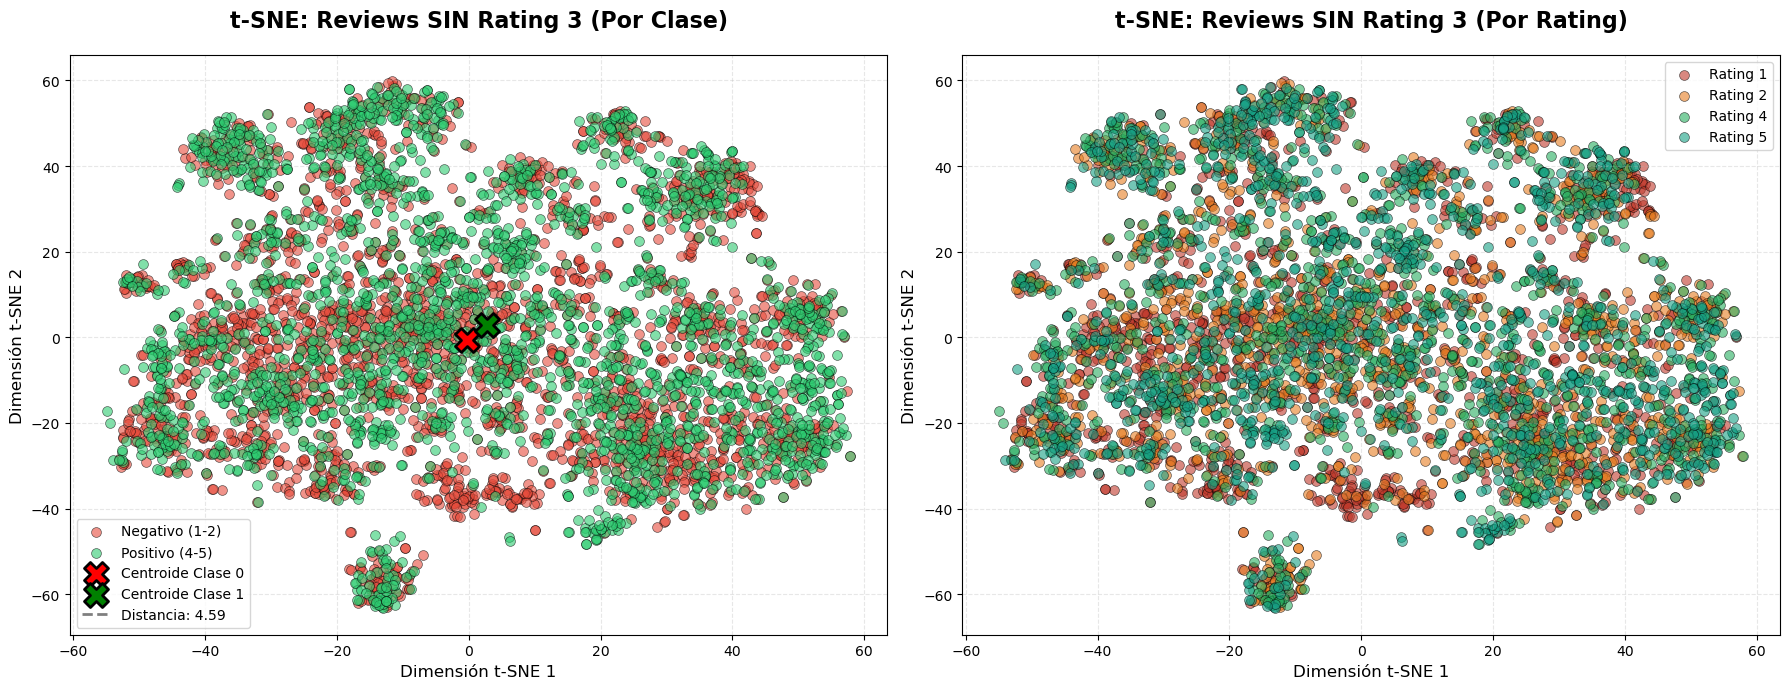

In [14]:
print("\n" + "="*60)
print("GENERANDO VISUALIZACIONES")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Colores
colors_clase = {0: '#e74c3c', 1: '#2ecc71'}
labels_clase = {0: 'Negativo (1-2)', 1: 'Positivo (4-5)'}

# ===== GRÁFICO 1: Por Clase =====
for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    axes[0].scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

# Marcar centroides
axes[0].scatter(centroid_0['x'], centroid_0['y'], c='red', marker='X', 
                s=300, edgecolors='black', linewidth=2, label='Centroide Clase 0', zorder=5)
axes[0].scatter(centroid_1['x'], centroid_1['y'], c='green', marker='X', 
                s=300, edgecolors='black', linewidth=2, label='Centroide Clase 1', zorder=5)

# Línea entre centroides
axes[0].plot([centroid_0['x'], centroid_1['x']], 
             [centroid_0['y'], centroid_1['y']], 
             'k--', linewidth=2, alpha=0.5, label=f'Distancia: {distance:.2f}')

axes[0].set_title('t-SNE: Reviews SIN Rating 3 (Por Clase)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Dimensión t-SNE 1', fontsize=12)
axes[0].set_ylabel('Dimensión t-SNE 2', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')
colors_rating = {1: '#c0392b', 2: '#e67e22', 4: '#27ae60', 5: '#16a085'}

for rating in sorted(df_tsne['rating'].unique()):
    mask = df_tsne['rating'] == rating
    axes[1].scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_rating[rating],
        label=f'Rating {rating}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

axes[1].set_title('t-SNE: Reviews SIN Rating 3 (Por Rating)', 
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Dimensión t-SNE 1', fontsize=12)
axes[1].set_ylabel('Dimensión t-SNE 2', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('tsne_sin_rating3.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_sin_rating3.png'")
plt.show()


✓ Guardado: 'tsne_sin_rating3_densidad.png'


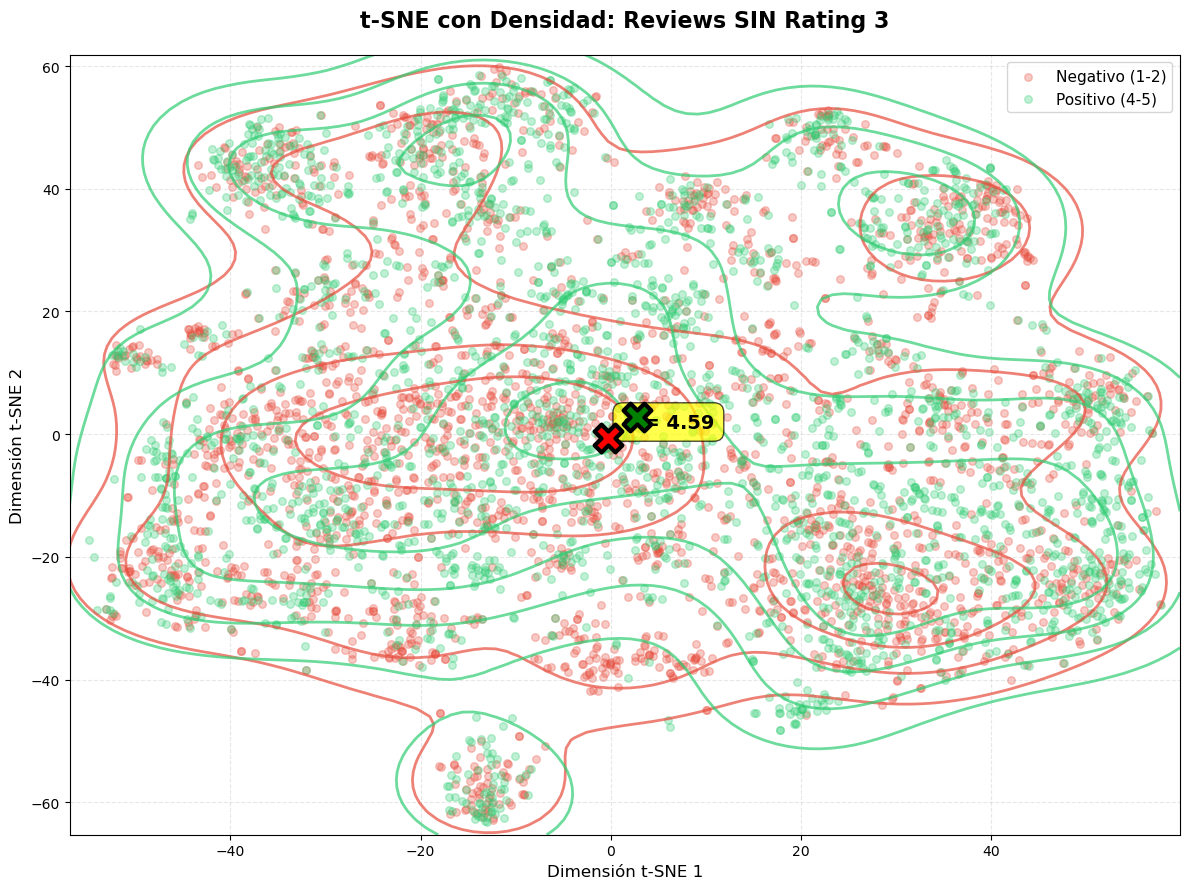

In [15]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(figsize=(12, 9))

# Scatter plots con transparencia
for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    ax.scatter(
        df_tsne[mask]['x'], 
        df_tsne[mask]['y'],
        c=colors_clase[clase],
        label=labels_clase[clase],
        alpha=0.3,
        s=30
    )

# Contornos de densidad
for clase in [0, 1]:
    mask = df_tsne['clase'] == clase
    xy = df_tsne[mask][['x', 'y']].values.T
    
    if len(xy[0]) > 10:
        kde = gaussian_kde(xy)
        
        # Grid
        x_min, x_max = df_tsne['x'].min() - 2, df_tsne['x'].max() + 2
        y_min, y_max = df_tsne['y'].min() - 2, df_tsne['y'].max() + 2
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        
        # Densidad
        density = kde(positions).reshape(xx.shape)
        
        # Contornos
        ax.contour(xx, yy, density, colors=colors_clase[clase], 
                   alpha=0.7, linewidths=2, levels=5)

# Centroides
ax.scatter(centroid_0['x'], centroid_0['y'], c='red', marker='X', 
          s=400, edgecolors='black', linewidth=3, zorder=5)
ax.scatter(centroid_1['x'], centroid_1['y'], c='green', marker='X', 
          s=400, edgecolors='black', linewidth=3, zorder=5)

# Línea entre centroides
ax.plot([centroid_0['x'], centroid_1['x']], 
        [centroid_0['y'], centroid_1['y']], 
        'k--', linewidth=3, alpha=0.7)

# Anotación de distancia
mid_x = (centroid_0['x'] + centroid_1['x']) / 2
mid_y = (centroid_0['y'] + centroid_1['y']) / 2
ax.annotate(f'd = {distance:.2f}', 
           xy=(mid_x, mid_y), fontsize=14, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_title('t-SNE con Densidad: Reviews SIN Rating 3', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Dimensión t-SNE 1', fontsize=12)
ax.set_ylabel('Dimensión t-SNE 2', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('tsne_sin_rating3_densidad.png', dpi=300, bbox_inches='tight')
print("✓ Guardado: 'tsne_sin_rating3_densidad.png'")
plt.show()

In [ ]:
print("\n" + "="*60)
print("RESUMEN EJECUTIVO")
print("="*60)

print(f"\n📊 DATOS:")
print(f"  • Reviews originales:        {len(df):,}")
print(f"  • Reviews después filtrado:  {len(df_filtered):,}")
print(f"  • Muestra para t-SNE:        {len(df_sample):,}")

print(f"\n⏱️ TIEMPOS:")
print(f"  • TF-IDF:  {tfidf_time:.2f}s")
print(f"  • PCA:     {pca_time:.2f}s")
print(f"  • t-SNE:   {tsne_time:.2f}s")
print(f"  • TOTAL:   {tfidf_time + pca_time + tsne_time:.2f}s")

print(f"\n🎯 SEPARABILIDAD:")
print(f"  • Distancia anterior (con rating 3): 2.34")
print(f"  • Distancia nueva (sin rating 3):    {distance:.2f}")
print(f"  • Mejora:                             {((distance/2.34)-1)*100:+.1f}%")

print(f"\n📈 PREDICCIÓN PARA NAIVE BAYES:")
if distance > 10:
    print("  ✅ Se espera GRAN mejora en el recall de clase 1")
    print("  ✅ Recall esperado: 70-85% (vs 35% actual)")
    print("  ✅ F1-score esperado: 0.75-0.85 (vs 0.50 actual)")
elif distance > 5:
    print("  ⚠️ Se espera mejora moderada en el recall de clase 1")
    print("  ⚠️ Recall esperado: 50-65% (vs 35% actual)")
else:
    print("  ❌ Mejora limitada, considerar otras técnicas")

print("\n✅ Visualizaciones guardadas:")
print("  • tsne_sin_rating3.png")
print("  • tsne_sin_rating3_densidad.png")

print("\n" + "="*60)
print("SIGUIENTE PASO: Reentrenar Naive Bayes sin rating 3")
print("="*60)


RESUMEN EJECUTIVO

📊 DATOS:
  • Reviews originales:        3,629,444
  • Reviews después filtrado:  2,903,016
  • Muestra para t-SNE:        4,999

⏱️ TIEMPOS:
  • TF-IDF:  1.02s
  • PCA:     0.89s
  • t-SNE:   19.73s
  • TOTAL:   21.64s

🎯 SEPARABILIDAD:
  • Distancia anterior (con rating 3): 2.34
  • Distancia nueva (sin rating 3):    4.59
  • Mejora:                             +96.1%

📈 PREDICCIÓN PARA NAIVE BAYES:
  ❌ Mejora limitada, considerar otras técnicas

✅ Visualizaciones guardadas:
  • tsne_sin_rating3.png
  • tsne_sin_rating3_densidad.png

SIGUIENTE PASO: Reentrenar Naive Bayes sin rating 3


: 